# Exploration of data to determine a test and training set

In [105]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray.plot as xplt
import cftime
import glob

In [106]:
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
platecarree = ccrs.PlateCarree()

In [113]:
glob.glob('../../../../derived_data/60km-regrid-2.2km-lin-london/rcp85/01/*/day/*_rcp85_land-gcm_uk_60km_01_day_19801201-19811130.nc')

['../../../../derived_data/60km-regrid-2.2km-lin-london/rcp85/01/psl/day/psl_rcp85_land-gcm_uk_60km_01_day_19801201-19811130.nc',
 '../../../../derived_data/60km-regrid-2.2km-lin-london/rcp85/01/pr/day/pr_rcp85_land-gcm_uk_60km_01_day_19801201-19811130.nc']

In [114]:
london_gcmdata = xr.open_mfdataset(glob.glob("../../../../derived_data/60km-london/rcp85/01/*/day/*_rcp85_land-gcm_uk_60km_01_day_19801201-19811130.nc"))
london_linear_regridded_gcmdata = xr.open_mfdataset(glob.glob('../../../../derived_data/60km-regrid-2.2km-lin-london/rcp85/01/*/day/*_rcp85_land-gcm_uk_60km_01_day_19801201-19811130.nc'))
london_nn_regridded_gcmdata = xr.open_mfdataset(glob.glob('../../../../derived_data/60km-regrid-2.2km-nn-london/rcp85/01/*/day/*_rcp85_land-gcm_uk_60km_01_day_19801201-19811130.nc'))
london_cpmdata = xr.open_mfdataset("../../../../derived_data/2.2km-london/rcp85/01/pr/day/pr_rcp85_land-cpm_uk_2.2km_01_day_19801201-19811130.nc")

In [115]:
def plot_latlong_chunk(data, variable='pr'):
    plt.figure(figsize=(14,6))

    ax = plt.axes(projection=cp_model_rotated_pole)

    data[variable].plot(ax=ax, x='longitude', y='latitude', add_colorbar=False, transform=platecarree)

    ax.coastlines()
    
    plt.show()

In [116]:
def plot_rp_chunk(data, variable='pr'):
    plt.figure(figsize=(14,6))

    ax = plt.axes(projection=cp_model_rotated_pole)

    data[variable].plot(ax=ax, x='grid_longitude', y='grid_latitude', add_colorbar=False, transform=cp_model_rotated_pole)

    ax.coastlines()
    
    plt.show()

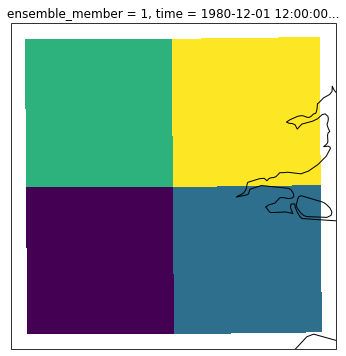

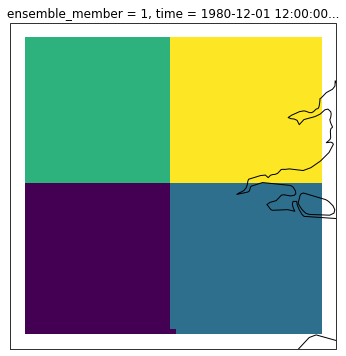

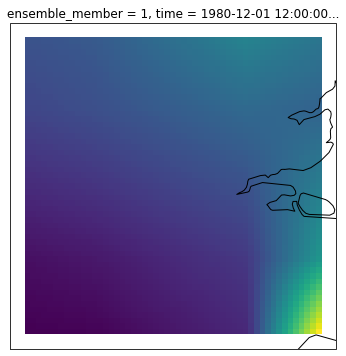

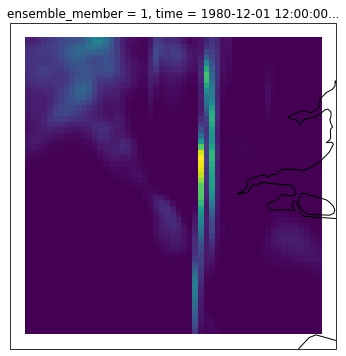

In [117]:
plot_latlong_chunk(london_gcmdata.sel(time="1980-12-01"), variable='pr')
plot_rp_chunk(london_nn_regridded_gcmdata.sel(time="1980-12-01"), variable='pr')
plot_rp_chunk(london_linear_regridded_gcmdata.sel(time="1980-12-01"), variable='pr')
plot_latlong_chunk(london_cpmdata.sel(time="1980-12-01"))

In [118]:
london_data = xr.merge([london_linear_regridded_gcmdata, london_cpmdata.rename({'pr': 'target_pr', 'ensemble_member_id': 'cpm_ensemble_member_id'})], join='inner').isel(ensemble_member=0)
london_data

<xarray.Dataset>
Dimensions:                     (bnds: 2, grid_latitude: 53, grid_longitude: 53, time: 360)
Coordinates:
    ensemble_member             int32 1
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-11...
  * grid_latitude               (grid_latitude) float64 -1.5 -1.48 ... -0.46
  * grid_longitude              (grid_longitude) float64 361.1 361.1 ... 362.1
    ensemble_member_id          |S27 dask.array<chunksize=(), meta=np.ndarray>
    month_number                (time) int32 dask.array<chunksize=(360,), meta=np.ndarray>
    year                        (time) int32 dask.array<chunksize=(360,), meta=np.ndarray>
    yyyymmdd                    (time) |S64 dask.array<chunksize=(360,), meta=np.ndarray>
    cpm_ensemble_member_id      |S27 dask.array<chunksize=(), meta=np.ndarray>
    latitude                    (grid_latitude, grid_longitude) float64 dask.array<chunksize=(53, 53), meta=np.ndarray>
    longitude                   (grid_latitude, grid_longitude) float64 dask.array<chunksize=(53, 53), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr                          (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 53, 53), meta=np.ndarray>
    rotated_latitude_longitude  int32 -2147483647
    time_bnds                   (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    grid_latitude_bnds          (grid_latitude, bnds) float64 dask.array<chunksize=(53, 2), meta=np.ndarray>
    grid_longitude_bnds         (grid_longitude, bnds) float64 dask.array<chunksize=(53, 2), meta=np.ndarray>
    psl                         (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 53, 53), meta=np.ndarray>
    target_pr                   (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 53, 53), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [119]:
import torch

variables = ('pr', 'psl')
unstacked_X = [torch.tensor(london_data[variable].values) for variable in variables]

X = torch.stack(list(unstacked_X), dim=1)
y = torch.tensor(london_data['target_pr'].values).unsqueeze(dim=1)

In [120]:
X.shape

torch.Size([360, 2, 53, 53])

In [121]:
y.shape

torch.Size([360, 1, 53, 53])

In [122]:
london_cpmdata.ensemble_member_id.values

array([b'HadREM3-RA11M-r001i1p00000 '], dtype='|S27')

# Extract wettest 10% of days

In [125]:
london_gcmdata

<xarray.Dataset>
Dimensions:                       (bnds: 2, ensemble_member: 1, projection_x_coordinate: 2, projection_y_coordinate: 2, time: 360)
Coordinates:
  * ensemble_member               (ensemble_member) int32 1
  * time                          (time) object 1980-12-01 12:00:00 ... 1981-...
  * projection_y_coordinate       (projection_y_coordinate) float64 1.5e+05 2...
  * projection_x_coordinate       (projection_x_coordinate) float64 5.1e+05 5...
    ensemble_member_id            (ensemble_member) |S27 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    month_number                  (time) int32 dask.array<chunksize=(360,), meta=np.ndarray>
    year                          (time) int32 dask.array<chunksize=(360,), meta=np.ndarray>
    yyyymmdd                      (time) |S64 dask.array<chunksize=(360,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr                            (ensemble_member, time, projection_y_coordinate, projection_x_coordinate) float32 dask.array<chunksize=(1, 360, 2, 2), meta=np.ndarray>
    transverse_mercator           int32 -2147483647
    time_bnds                     (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (projection_y_coordinate, bnds) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    projection_x_coordinate_bnds  (projection_x_coordinate, bnds) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    psl                           (ensemble_member, time, projection_y_coordinate, projection_x_coordinate) float32 dask.array<chunksize=(1, 360, 2, 2), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.5

In [126]:
# Find the timestamps of the wettest 100 days (for a single ensemble member), where wetness of a day is defined simply as the summation of pr of all the grid squares for that day
wettest_100_days = london_gcmdata.isel(ensemble_member=0).sum(dim=['projection_x_coordinate', 'projection_y_coordinate']).sortby('pr').isel(time=slice(-101, -1)).time.values

In [124]:
wettest_100_london_gcmdata = london_gcmdata.where(london_gcmdata.time.isin(wettest_100_days), drop=True)
wettest_100_london_gcmdata

NameError: name 'wettest_100_days' is not defined

# Turn numpy variable files into Dataloader

In [27]:
import torch

In [19]:
from torch.utils.data import random_split, DataLoader, Dataset, TensorDataset

In [37]:
variables = ['pr', 'psl']
lo_res_files = [ f'../../../../derived_data/60km-2.2km-regrid-lin-london/numpy/rcp85/01/{var}/day/{var}.npy' for var in variables ]

unstacked_X = map(torch.tensor, map(np.load, lo_res_files))
X = torch.stack(list(unstacked_X), dim=1)

hi_res_file = '../../../../derived_data/2.2km-london/numpy/rcp85/01/pr/day/pr.npy'

y = torch.tensor(np.load(hi_res_file)).unsqueeze(dim=1)

all_data = TensorDataset(X, y)

train_size = int(0.7 * len(all_data))
val_size = len(all_data) - train_size
train_set, val_set = random_split(all_data, [train_size, val_size])

train_dl = DataLoader(train_set, batch_size=64)
val_dl = DataLoader(val_set, batch_size=64)

In [1]:
from ml_downscaling_emulator.helpers import load_dataset

In [9]:
london_gcm_psl = load_dataset("60km-regrid-2.2km-lin-london", "gcm", "psl", range(1980, 1990))
london_gcm_pr = load_dataset("60km-regrid-2.2km-lin-london", "gcm", "pr", range(1980, 1990))
london_cpm_pr = load_dataset("2.2km-london", "cpm", "pr", range(1980, 1990))

In [136]:
test_london_gcm_psl = london_gcm_psl.where(london_gcm_psl.time.isin(wettest_100_days), drop=True)
test_london_gcm_pr = london_gcm_pr.where(london_gcm_pr.time.isin(wettest_100_days), drop=True)
test_london_cpm_pr = london_cpm_pr.where(london_cpm_pr.time.isin(wettest_100_days), drop=True)

train_london_gcm_psl = london_gcm_psl.where(london_gcm_psl.time.isin(wettest_100_days) == False, drop=True)
train_london_gcm_pr = london_gcm_pr.where(london_gcm_pr.time.isin(wettest_100_days) == False, drop=True)
train_london_cpm_pr = london_cpm_pr.where(london_cpm_pr.time.isin(wettest_100_days) == False, drop=True)

In [137]:
train_london_gcm_psl

<xarray.Dataset>
Dimensions:                     (bnds: 2, ensemble_member: 1, grid_latitude: 53, grid_longitude: 53, time: 3500)
Coordinates:
  * ensemble_member             (ensemble_member) int32 1
  * time                        (time) object 1980-12-01 12:00:00 ... 1990-11...
  * grid_latitude               (grid_latitude) float64 -1.5 -1.48 ... -0.46
  * grid_longitude              (grid_longitude) float64 361.1 361.1 ... 362.1
    ensemble_member_id          (ensemble_member) |S27 b'HadGEM3-GC3.05-r001i...
    month_number                (time) int32 12 12 12 12 12 ... 11 11 11 11 11
    year                        (time) int32 1980 1980 1980 ... 1990 1990 1990
    yyyymmdd                    (time) |S64 b'19801201                       ...
Dimensions without coordinates: bnds
Data variables:
    psl                         (ensemble_member, time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  (time) float64 -2.147e+09 ... -2.147e+09
    time_bnds                   (time, bnds) object 1980-12-01 00:00:00 ... 1...
    grid_latitude_bnds          (time, grid_latitude, bnds) float64 -1.51 ......
    grid_longitude_bnds         (time, grid_longitude, bnds) float64 361.0 .....
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T19:32:06
    description:     Sea level pressure
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, sea...
    version:         v20181122
    Conventions:     CF-1.7

In [138]:
test_london_gcm_psl

<xarray.Dataset>
Dimensions:                     (bnds: 2, ensemble_member: 1, grid_latitude: 53, grid_longitude: 53, time: 100)
Coordinates:
  * ensemble_member             (ensemble_member) int32 1
  * time                        (time) object 1980-12-04 12:00:00 ... 1981-11...
  * grid_latitude               (grid_latitude) float64 -1.5 -1.48 ... -0.46
  * grid_longitude              (grid_longitude) float64 361.1 361.1 ... 362.1
    ensemble_member_id          (ensemble_member) |S27 b'HadGEM3-GC3.05-r001i...
    month_number                (time) int32 12 12 12 12 12 ... 11 11 11 11 11
    year                        (time) int32 1980 1980 1980 ... 1981 1981 1981
    yyyymmdd                    (time) |S64 b'19801204                       ...
Dimensions without coordinates: bnds
Data variables:
    psl                         (ensemble_member, time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  (time) float64 -2.147e+09 ... -2.147e+09
    time_bnds                   (time, bnds) object 1980-12-04 00:00:00 ... 1...
    grid_latitude_bnds          (time, grid_latitude, bnds) float64 -1.51 ......
    grid_longitude_bnds         (time, grid_longitude, bnds) float64 361.0 .....
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T19:32:06
    description:     Sea level pressure
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, sea...
    version:         v20181122
    Conventions:     CF-1.7

In [14]:
london_merged = xr.merge([london_gcm_psl, london_gcm_pr, london_cpm_pr.rename({'pr': 'target_pr', 'ensemble_member_id': 'cpm_ensemble_member_id'})], join='inner')

In [139]:
test_london_merged = london_merged.where(london_merged.time.isin(wettest_100_days) == True, drop=True)

train_london_merged = london_merged.where(london_merged.time.isin(wettest_100_days) == False, drop=True)

In [97]:
class XRDataset(Dataset):
    def __init__(self, ds, variables):
        self.ds = ds
        self.variables = variables

    def __len__(self):
        return len(self.ds.time)

    def __getitem__(self, idx):
        subds = self.ds.isel(time=idx, ensemble_member=0)
        
        X = torch.tensor(np.stack([subds[var].values for var in self.variables], axis=0))
        y = torch.tensor(np.stack([subds["target_pr"].values], axis=0))
        return X, y

In [140]:
ptds = XRDataset(train_london_merged, ['pr', 'psl'])

In [141]:
ptds.__getitem__(0)[1][0,:,:] == torch.tensor(train_london_merged.isel(ensemble_member=0)['target_pr'].values[0])

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [68]:
raw_tr = torch.tensor(np.stack([london_merged.isel(ensemble_member=0)[var].values for var in ['pr', 'psl']+['target_pr']], axis=1))

In [73]:
torch.tensor(london_merged.isel(ensemble_member=0)['target_pr'].values[0]) == raw_tr[0][2]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [71]:
raw_tr[0][2]

tensor([[1.2268e-05, 9.5134e-06, 1.3220e-05,  ..., 5.9425e-06, 5.5811e-06,
         5.9465e-06],
        [5.7181e-06, 6.4309e-06, 2.5258e-05,  ..., 6.5326e-06, 5.4813e-06,
         5.7698e-06],
        [5.8641e-06, 5.3123e-06, 6.2963e-06,  ..., 7.5854e-06, 6.4971e-06,
         6.1939e-06],
        ...,
        [3.2435e-01, 3.4263e-01, 3.6595e-01,  ..., 1.3649e-05, 1.6395e-05,
         7.7446e-05],
        [2.7967e-01, 2.9309e-01, 3.4249e-01,  ..., 1.3705e-05, 1.6970e-05,
         6.4990e-05],
        [2.1614e-01, 2.1018e-01, 2.6036e-01,  ..., 1.3155e-05, 1.3877e-05,
         1.9336e-05]])